# Wine Spirit

Studying wines for a company

In [50]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sb
from scipy.stats import zscore, iqr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import winelib as wl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I. Importing data from Excel files

In [51]:
erp_df = pd.read_excel("..\data\RAW\erp.xlsx")
liaison_df = pd.read_excel("..\data\RAW\liaison.xlsx")
web_df = pd.read_excel("..\data\RAW\web.xlsx")

C:\Users\simplon\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## II. Analysis
### 1. Exploring the data

First, I need to explore what columns are important to keep datawise

In [52]:
web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

In [53]:
web_df.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count
count,1513.0,1513.0,1513.0,1430.0,1430.000000,0.0,1430.000000,0.0,0.0,0.0,1430.0,1430.0,1430.0
mean,0.0,0.0,0.0,0.0,4.006993,NaN,1.998601,NaN,NaN,NaN,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,8.510559,NaN,0.037385,NaN,NaN,NaN,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN,NaN,NaN,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,4.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,96.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0


From the .info and .describe I can see that some columns have only NaN values and others have only '0' values.\n
We'll not need these for any analysis.

In [54]:
web_df.groupby('sku')['sku'].count()

sku
38                     2
41                     2
304                    2
523                    2
531                    2
                      ..
19820                  2
19821                  2
19822                  2
13127-1                2
bon-cadeau-25-euros    2
Name: sku, Length: 714, dtype: int64

In [55]:
web_df['sku'].str.contains("bon-cadeau-25-euros").sort_values()

797     False
1511    False
0        True
1209     True
1         NaN
        ...  
1507      NaN
1508      NaN
1509      NaN
1510      NaN
1512      NaN
Name: sku, Length: 1513, dtype: object

In [56]:

pd.DataFrame((web_df.iloc[0], web_df.iloc[1209]))

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
1209,bon-cadeau-25-euros,0,0,0,0.0,10.0,NaN,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.wine-spirit.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [57]:
web_df_clean = wl.cleaning_web_df(web_df)

In [58]:
fusion = wl.merge_tables(erp_df, liaison_df, web_df_clean)

In [59]:
fusion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 713
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         714 non-null    int64         
 1   onsale_web         714 non-null    int64         
 2   price              714 non-null    float64       
 3   stock_quantity     714 non-null    int64         
 4   stock_status       714 non-null    object        
 5   id_web             714 non-null    object        
 6   sku                714 non-null    object        
 7   total_sales        714 non-null    float64       
 8   tax_status         714 non-null    object        
 9   post_author        714 non-null    float64       
 10  post_date          714 non-null    datetime64[ns]
 11  post_date_gmt      714 non-null    datetime64[ns]
 12  post_title         714 non-null    object        
 13  post_excerpt       714 non-null    object        
 14  post_statu

C:\Users\simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

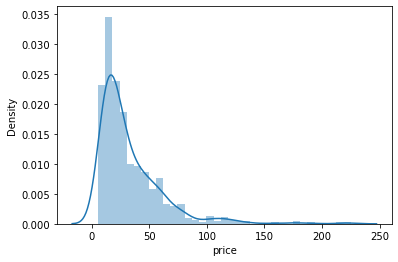

In [60]:
sb.distplot(fusion['price'])

In [61]:
fusion['turnover'] = fusion['total_sales'] * fusion['price']

C:\Users\simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='turnover', ylabel='Density'>

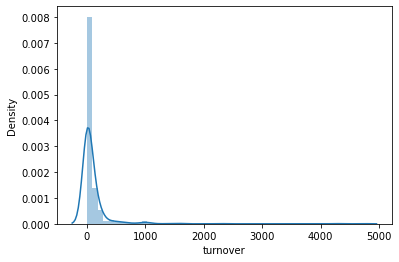

In [62]:
sb.distplot(fusion['turnover'])

In [63]:
fusion['turnover'].sum()

70568.6

C:\Users\simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

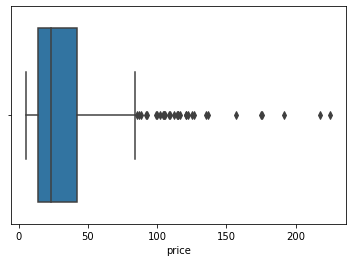

In [64]:
sb.boxplot(fusion['price'])

In [65]:
outliers_zscore = wl.outliers_zscore(fusion, 'price')
len(outliers_zscore)/len(fusion)

0.04201680672268908

In [66]:
outliers_iqr = wl.outliers_iqr(fusion, 'price')
len(outliers_iqr)/len(fusion)

0.04481792717086835

In [68]:
fusion['outlier'] = fusion.price.isin(outliers_zscore.price)

C:\Users\simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='total_sales'>

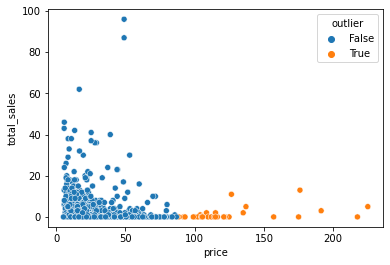

In [69]:
sb.scatterplot(fusion['price'], fusion['total_sales'], hue = fusion['outlier'])

In [112]:
x_train, x_test  = train_test_split(fusion[['price', 'total_sales']], test_size = 0.3, random_state = 42)
len(x_train), len(x_test)

(499, 215)

In [113]:
x_test

,price,total_sales
120,38.0,0.0
329,7.4,0.0
39,22.9,0.0
294,9.1,6.0
654,121.0,0.0
...,...,...
534,31.7,0.0
393,7.0,10.0
382,22.9,0.0
223,28.1,3.0


In [114]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(x_train)
kmeans.labels_

array([2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 3,
       2, 0, 2, 0, 4, 2, 2, 1, 1, 2, 0, 1, 2, 3, 0, 2, 1, 0, 0, 2, 2, 0,
       1, 2, 3, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2,
       0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 2,
       1, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 4,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2,
       2, 3, 2, 0, 0, 2, 0, 3, 2, 0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 0, 2, 2,
       0, 0, 2, 0, 2, 2, 0, 2, 0, 3, 2, 0, 3, 2, 3, 2, 2, 2, 0, 0, 2, 0,
       0, 2, 2, 1, 2, 1, 0, 2, 2, 0, 2, 0, 0, 2, 4, 2, 0, 1, 0, 1, 0, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 2,
       0, 1, 0, 2, 2, 0, 4, 2, 2, 2, 1, 0, 0, 3, 2, 2, 1, 2, 2, 2, 2, 1,
       0, 1, 2, 2, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2,
       0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 2,

In [115]:
x_train['cluster'] = kmeans.labels_
x_train

,price,total_sales,cluster
28,20.8,20.0,2
43,17.0,0.0,2
42,39.0,4.0,0
73,33.0,3.0,0
167,9.6,3.0,2
...,...,...,...
71,49.0,87.0,4
106,16.7,3.0,2
270,36.2,0.0,0
435,19.8,0.0,2


In [116]:

predict = kmeans.predict(x_test)
predict

array([0, 2, 2, 2, 3, 0, 1, 2, 2, 4, 0, 4, 2, 2, 0, 2, 2, 0, 0, 2, 2, 1,
       2, 3, 0, 0, 3, 0, 2, 0, 4, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1,
       0, 2, 2, 2, 1, 1, 4, 0, 2, 2, 2, 2, 3, 1, 0, 2, 1, 0, 2, 0, 1, 2,
       2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 1, 2,
       2, 2, 0, 2, 2, 3, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 4, 4, 0, 2, 2, 2, 1, 2, 3, 0, 2, 2, 4, 1, 2,
       2, 2, 0, 1, 1, 1, 3, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 1, 0, 2, 3, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2, 3, 0, 2, 2, 0, 2])

In [117]:
x_test['cluster'] = predict

In [118]:
kmeans.cluster_centers_

array([[ 37.58405797,   2.21014493],
       [ 65.55873016,   0.82539683],
       [ 15.59099265,   4.13602941],
       [125.42352941,   1.82352941],
       [ 24.76666667,  49.44444444]])

C:\Users\simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


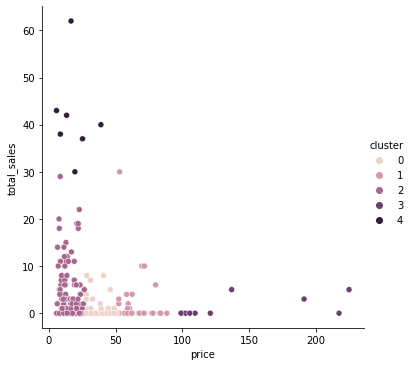

In [119]:
sb.relplot(x_test['price'], x_test['total_sales'], hue=x_test['cluster'])